# Project 7: Home Credit Default Risk

We have 9 files of information about a bank's customers with decision from the bank about loan. 
If the target is equal to 0: the loan was repaid, if it's equal to 1: the loan was not repaid.

There is one more file with information about new customers. The bank wants to know if they should give them a loan or not. The machine learning model needs to predict if the client will repay the loan or not.
The models will determine if the loan will be repaid or not according to the given features.

### Summary

- Data reading
- Data analysis and clean
- Machine Learning Models:
    - split data
    - checking imbalanced data:
        - SMOTE
        - Random Under-Sampling
    - Classification models:
        - Comparison defalt models:
            - Dummy
            - Random Forest
            - Decision Tree
            - XGBoost
            - LGBM
        - Comparison models with SMOTE under-sampling
        - Comparison models with Random under-sampling
    - Feature importance (for random-undersampled data)
        - Global feature importance
        - Local feature importance (SHAP method)
    - Grid Search and Cross Validation
        - Cross Validation
        - Searching hyperparameters
- Prediction on test data

### Library

In [265]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gc
import time
import pickle
import imblearn
import shap
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import make_scorer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

### Data

In [1]:
path = '/Users/alexandrasheremet/Desktop/Alexandra Sheremet/Data Science/projet_7/Projet+Mise+en+prod+-+home-credit-default-risk'

In [3]:
csv_files = glob.glob(os.path.join(path, "*.csv"))

In [4]:
file_app_test = pd.read_csv(csv_files[0], sep = ',',low_memory = False)
file_app_home_credit = pd.read_csv(csv_files[1], sep = ',',low_memory = False, encoding = 'cp1252')
file_cash_balance = pd.read_csv(csv_files[2], sep = ',',low_memory = False)
file_cred_card = pd.read_csv(csv_files[3], sep = ',',low_memory = False)
file_inst_payment = pd.read_csv(csv_files[4], sep = ',',low_memory = False)
file_app_train = pd.read_csv(csv_files[5], sep = ',',low_memory = False)
file_bureau = pd.read_csv(csv_files[6], sep = ',',low_memory = False)
file_prev_appl = pd.read_csv(csv_files[7], sep = ',',low_memory = False)
file_bureau_balance = pd.read_csv(csv_files[8], sep = ',',low_memory = False)
file_submis = pd.read_csv(csv_files[9], sep = ',',low_memory = False)

In [6]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))   

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [7]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    #df = pd.read_csv('../input/application_train.csv', nrows = num_rows)
    df = pd.read_csv(csv_files[5], nrows = num_rows)
    #test_df = pd.read_csv('../input/application_test.csv', nrows = num_rows)
    test_df = pd.read_csv(csv_files[0], nrows = num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    #bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    bureau = pd.read_csv(csv_files[6], nrows = num_rows)
    #bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)
    bb = pd.read_csv(csv_files[8], nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    #prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
    prev = pd.read_csv(csv_files[7], nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category = True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace = True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace = True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace = True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace = True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace = True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how = 'left', on = 'SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    #pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
    pos = pd.read_csv(csv_files[2], nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    #ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
    ins = pd.read_csv(csv_files[4], nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    #cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
    cc = pd.read_csv(csv_files[3], nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [8]:
def main(debug = False):
      
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how ='left', on ='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how = 'left', on = 'SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how = 'left', on = 'SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how = 'left', on = 'SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how = 'left', on = 'SK_ID_CURR')
        del cc
        gc.collect()
        
    return df

In [9]:
df = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 14s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 15s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s
Installments payments df shape: (339587, 26)
Process installments payments - done in 23s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 10s


In [10]:
df

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           0      100002     1.0            0             0                0   
1           1      100003     0.0            1             0                1   
2           2      100004     0.0            0             1                0   
3           3      100006     0.0            1             0                0   
4           4      100007     0.0            0             0                0   
...       ...         ...     ...          ...           ...              ...   
356250  48739      456221     NaN            1             0                0   
356251  48740      456222     NaN            1             0                1   
356252  48741      456223     NaN            1             1                0   
356253  48742      456224     NaN            0             0                1   
356254  48743      456250     NaN            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0                  0          202500.0    406597.5      24700.5  ...   
1                  0          270000.0   1293502.5      35698.5  ...   
2                  0           67500.0    135000.0       6750.0  ...   
3                  0          135000.0    312682.5      29686.5  ...   
4                  0          121500.0    513000.0      21865.5  ...   
...              ...               ...         ...          ...  ...   
356250             0          121500.0    412560.0      17473.5  ...   
356251             2          157500.0    622413.0      31909.5  ...   
356252             1          202500.0    315000.0      33205.5  ...   
356253             0          225000.0    450000.0      25128.0  ...   
356254             0          135000.0    312768.0      24709.5  ...   

        CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      0.0   
4                                      NaN   
...                                    ...   
356250                                 NaN   
356251                                 NaN   
356252                                 NaN   
356253                                 NaN   
356254                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       0.0   
4                                       NaN   
...                                     ...   
356250                                  NaN   
356251                                  NaN   
356252                                  NaN   
356253                                  NaN   
356254                                  0.0   

        CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      0.0   
4                                      NaN   
...                                    ...   
356250                                 NaN   
356251                                 NaN   
356252                                 NaN   
356253                                 NaN   
356254                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                      NaN                              NaN   
1                                      NaN                              NaN   
2                                      NaN                              NaN   
3                                      0.0                              0.0   
4                                      NaN                              NaN   
...                      

### Analyse of data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 798 entries, index to CC_COUNT
dtypes: float64(622), int64(43), uint8(133)
memory usage: 1.8 GB


In [12]:
def plot_hist_data(data):
    feats = [f for f in data.columns if f not in ['index','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]
    num_cols = [col for col in feats if df[col].dtype != 'object'] 
    
    num_cols_fin = [col for col in num_cols if df[[col]].max().values[0] != np.inf]
        
    height = int(np.ceil(len(num_cols)/6))
    fig_height = 3*height
    fig = plt.figure(figsize = (20, fig_height))
    
    for feat_idx, col in enumerate(num_cols_fin):
        ax = fig.add_subplot(height, 6, feat_idx+1)
        ax.hist(data[col], bins = 30)
        ax.set_title(col)
    fig.tight_layout(pad = 4)  

In [13]:
plot_hist_data(df)

### Clean of data

##### Outliers

In [14]:
def z_score(array, threshold = 3):
    '''Return an array of boolean, True for each value in the array where Z-score > threshold.'''
    mean = array.mean()
    std = array.std()
    
    return abs((array - mean))/std > threshold

In [15]:
num_cols = [col for col in df.columns if df[col].dtype != 'object'] 
for feat_idx, col in enumerate(num_cols):
    nb_outliers = df[z_score(df[col])].shape[0]
    pc_outliers = nb_outliers/df.shape[0]
    if nb_outliers != 0:
        print(col, 'contains', nb_outliers, 'outliers that corresponds to ', round(pc_outliers, 4), 'of data')

TARGET contains 24825 outliers that corresponds to  0.0697 of data
CNT_CHILDREN contains 4878 outliers that corresponds to  0.0137 of data
AMT_INCOME_TOTAL contains 563 outliers that corresponds to  0.0016 of data
AMT_CREDIT contains 5117 outliers that corresponds to  0.0144 of data
AMT_ANNUITY contains 3481 outliers that corresponds to  0.0098 of data
AMT_GOODS_PRICE contains 5144 outliers that corresponds to  0.0144 of data
REGION_POPULATION_RELATIVE contains 9977 outliers that corresponds to  0.028 of data
DAYS_EMPLOYED contains 6487 outliers that corresponds to  0.0182 of data
DAYS_REGISTRATION contains 876 outliers that corresponds to  0.0025 of data
OWN_CAR_AGE contains 3834 outliers that corresponds to  0.0108 of data
FLAG_MOBIL contains 2 outliers that corresponds to  0.0 of data
FLAG_CONT_MOBILE contains 652 outliers that corresponds to  0.0018 of data
FLAG_EMAIL contains 25370 outliers that corresponds to  0.0712 of data
CNT_FAM_MEMBERS contains 4583 outliers that corresponds

NAME_EDUCATION_TYPE_Lower secondary contains 4291 outliers that corresponds to  0.012 of data
NAME_FAMILY_STATUS_Civil marriage contains 34035 outliers that corresponds to  0.0955 of data
NAME_FAMILY_STATUS_Separated contains 22725 outliers that corresponds to  0.0638 of data
NAME_FAMILY_STATUS_Unknown contains 2 outliers that corresponds to  0.0 of data
NAME_FAMILY_STATUS_Widow contains 18297 outliers that corresponds to  0.0514 of data
NAME_HOUSING_TYPE_Co-op apartment contains 1245 outliers that corresponds to  0.0035 of data
NAME_HOUSING_TYPE_Municipal apartment contains 12799 outliers that corresponds to  0.0359 of data
NAME_HOUSING_TYPE_Office apartment contains 3024 outliers that corresponds to  0.0085 of data
NAME_HOUSING_TYPE_Rented apartment contains 5599 outliers that corresponds to  0.0157 of data
NAME_HOUSING_TYPE_With parents contains 17074 outliers that corresponds to  0.0479 of data
OCCUPATION_TYPE_Accountants contains 11441 outliers that corresponds to  0.0321 of data


DAYS_EMPLOYED_PERC contains 4838 outliers that corresponds to  0.0136 of data
INCOME_CREDIT_PERC contains 2782 outliers that corresponds to  0.0078 of data
INCOME_PER_PERSON contains 2205 outliers that corresponds to  0.0062 of data
ANNUITY_INCOME_PERC contains 4412 outliers that corresponds to  0.0124 of data
BURO_DAYS_CREDIT_MAX contains 9501 outliers that corresponds to  0.0267 of data
BURO_DAYS_CREDIT_MEAN contains 1562 outliers that corresponds to  0.0044 of data
BURO_DAYS_CREDIT_VAR contains 4007 outliers that corresponds to  0.0112 of data
BURO_DAYS_CREDIT_ENDDATE_MIN contains 2606 outliers that corresponds to  0.0073 of data
BURO_DAYS_CREDIT_ENDDATE_MAX contains 3 outliers that corresponds to  0.0 of data
BURO_DAYS_CREDIT_ENDDATE_MEAN contains 5810 outliers that corresponds to  0.0163 of data
BURO_DAYS_CREDIT_UPDATE_MEAN contains 3987 outliers that corresponds to  0.0112 of data
BURO_CREDIT_DAY_OVERDUE_MAX contains 865 outliers that corresponds to  0.0024 of data
BURO_CREDIT_DA

CLOSED_CNT_CREDIT_PROLONG_SUM contains 3403 outliers that corresponds to  0.0096 of data
CLOSED_MONTHS_BALANCE_MAX_MAX contains 3287 outliers that corresponds to  0.0092 of data
CLOSED_MONTHS_BALANCE_SIZE_MEAN contains 6 outliers that corresponds to  0.0 of data
CLOSED_MONTHS_BALANCE_SIZE_SUM contains 6213 outliers that corresponds to  0.0174 of data
PREV_AMT_ANNUITY_MIN contains 6325 outliers that corresponds to  0.0178 of data
PREV_AMT_ANNUITY_MAX contains 5090 outliers that corresponds to  0.0143 of data
PREV_AMT_ANNUITY_MEAN contains 5531 outliers that corresponds to  0.0155 of data
PREV_AMT_APPLICATION_MIN contains 5253 outliers that corresponds to  0.0147 of data
PREV_AMT_APPLICATION_MAX contains 5960 outliers that corresponds to  0.0167 of data
PREV_AMT_APPLICATION_MEAN contains 6390 outliers that corresponds to  0.0179 of data
PREV_AMT_CREDIT_MIN contains 5158 outliers that corresponds to  0.0145 of data
PREV_AMT_CREDIT_MAX contains 6042 outliers that corresponds to  0.017 of d

PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN contains 9272 outliers that corresponds to  0.026 of data
PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN contains 3844 outliers that corresponds to  0.0108 of data
PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN contains 6459 outliers that corresponds to  0.0181 of data
PREV_NAME_GOODS_CATEGORY_Computers_MEAN contains 9845 outliers that corresponds to  0.0276 of data
PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN contains 6288 outliers that corresponds to  0.0177 of data
PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN contains 10785 outliers that corresponds to  0.0303 of data
PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN contains 388 outliers that corresponds to  0.0011 of data
PREV_NAME_GOODS_CATEGORY_Education_MEAN contains 95 outliers that corresponds to  0.0003 of data
PREV_NAME_GOODS_CATEGORY_Fitness_MEAN contains 183 outliers that corresponds to  0.0005 of data
PREV_NAME_GOODS_CATEGORY_Furniture_MEAN contains 7016 outliers t

APPROVED_HOUR_APPR_PROCESS_START_MEAN contains 1187 outliers that corresponds to  0.0033 of data
APPROVED_RATE_DOWN_PAYMENT_MIN contains 6517 outliers that corresponds to  0.0183 of data
APPROVED_RATE_DOWN_PAYMENT_MAX contains 7468 outliers that corresponds to  0.021 of data
APPROVED_RATE_DOWN_PAYMENT_MEAN contains 5734 outliers that corresponds to  0.0161 of data
APPROVED_DAYS_DECISION_MAX contains 10916 outliers that corresponds to  0.0306 of data
APPROVED_DAYS_DECISION_MEAN contains 1469 outliers that corresponds to  0.0041 of data
APPROVED_CNT_PAYMENT_MEAN contains 3311 outliers that corresponds to  0.0093 of data
APPROVED_CNT_PAYMENT_SUM contains 6440 outliers that corresponds to  0.0181 of data
REFUSED_AMT_ANNUITY_MIN contains 1749 outliers that corresponds to  0.0049 of data
REFUSED_AMT_ANNUITY_MAX contains 1510 outliers that corresponds to  0.0042 of data
REFUSED_AMT_ANNUITY_MEAN contains 1555 outliers that corresponds to  0.0044 of data
REFUSED_AMT_APPLICATION_MIN contains 317

CC_AMT_DRAWINGS_POS_CURRENT_MIN contains 431 outliers that corresponds to  0.0012 of data
CC_AMT_DRAWINGS_POS_CURRENT_MAX contains 1298 outliers that corresponds to  0.0036 of data
CC_AMT_DRAWINGS_POS_CURRENT_MEAN contains 948 outliers that corresponds to  0.0027 of data
CC_AMT_DRAWINGS_POS_CURRENT_SUM contains 1243 outliers that corresponds to  0.0035 of data
CC_AMT_DRAWINGS_POS_CURRENT_VAR contains 515 outliers that corresponds to  0.0014 of data
CC_AMT_INST_MIN_REGULARITY_MIN contains 2177 outliers that corresponds to  0.0061 of data
CC_AMT_INST_MIN_REGULARITY_MAX contains 2239 outliers that corresponds to  0.0063 of data
CC_AMT_INST_MIN_REGULARITY_MEAN contains 2475 outliers that corresponds to  0.0069 of data
CC_AMT_INST_MIN_REGULARITY_SUM contains 2277 outliers that corresponds to  0.0064 of data
CC_AMT_INST_MIN_REGULARITY_VAR contains 2184 outliers that corresponds to  0.0061 of data
CC_AMT_PAYMENT_CURRENT_MIN contains 399 outliers that corresponds to  0.0011 of data
CC_AMT_PAYM

##### Non-typical data

In [16]:
#Infinite values
num_cols_inf = [col for col in df.columns if df[[col]].max().values[0] == np.inf]
num_cols_inf

['PREV_APP_CREDIT_PERC_MAX',
 'REFUSED_APP_CREDIT_PERC_MAX',
 'INSTAL_PAYMENT_PERC_MAX']

In [17]:
df[num_cols_inf].describe()

PREV_APP_CREDIT_PERC_MAX  REFUSED_APP_CREDIT_PERC_MAX  \
count              3.386010e+05                 1.124530e+05   
mean                        inf                          inf   
std                         NaN                          NaN   
min                0.000000e+00                 0.000000e+00   
25%                1.000000e+00                 9.132090e-01   
50%                1.042350e+00                 1.000000e+00   
75%                1.132025e+00                 1.000000e+00   
max                         inf                          inf   

       INSTAL_PAYMENT_PERC_MAX  
count             3.395740e+05  
mean                       inf  
std                        NaN  
min               5.121918e-01  
25%               1.000000e+00  
50%               1.000000e+00  
75%               1.000000e+00  
max                        inf

In [18]:
day_cols = [col for col in df.columns if "DAYS" in col]
(df[day_cols].describe().loc[['min', 'max']].transpose()/365).style.format({'min':'{:,.2f}', 
                                                                                      'max':'{:,.2f}'})

In [19]:
def clean_values(df):
    print('Cleaning data')
    
    old_length = df.shape[0]
    result = df.copy()
    feats = [f for f in result.columns if f not in ['index','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','TARGET']]
    num_cols = [col for col in feats if result[col].dtype != 'object']
    cat_cols = [col for col in feats if col not in num_cols]
    
    high_z_score = result[num_cols].apply(z_score, axis = 0, args = [80])
    result.drop(high_z_score[high_z_score.any(axis = 1)].index, inplace = True)
    
    days_cols = [col for col in result.columns if "DAYS_" in col]
    for col in days_cols:
        result.loc[result[col] < result['DAYS_BIRTH'], col] = result['DAYS_BIRTH']
        result.loc[result[col] > 0, col] = 0
        
    #infinte values
    num_cols_inf = [col for col in df.columns if df[[col]].max().values[0] == np.inf]
    for col in num_cols_inf:
        result[col] = result[col].replace(np.inf, result[col].quantile(0.75))
        #mask_inf = result[col] == np.inf
        #result[col][mask_inf].replace(result[num_cols_inf].quantile(0.75))
    
    #missed values
    result_nan = result.copy()
    result_nan[num_cols] = result[num_cols].fillna(0)
    result_nan[cat_cols] = result[cat_cols].fillna('Not specified')
    
    new_length = result.shape[0]
    deleted_rows = old_length - new_length
    print(f'{deleted_rows} were removed that is {deleted_rows/old_length:.2%} of total.')
  
    return result, result_nan

In [20]:
data_clean, data_clean_nan = clean_values(df)

Cleaning data
623 were removed that is 0.17% of total.


In [21]:
#Splitting data
def split_data(df):
   
    # Divide in training/validation and test data
    import re
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()] 
    #del df
    gc.collect()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_x = train_df[feats]
    train_y = train_df['TARGET']
    test_x = test_df[feats]
    
    return train_x, train_y, test_x

In [22]:
train_x, train_y, test_x = split_data(data_clean)

train_x_wo_nan, train_y_wo_nan, test_x_wo_nan = split_data(data_clean_nan)

##### Writing information in files

In [154]:
data_in = [train_x_wo_nan, train_y_wo_nan, test_x_wo_nan]

In [155]:
# open a file
file_data_wo_nan = open('data_wo_nan', 'wb')

# dump information to that file
pickle.dump(data_in, file_data_wo_nan)

# close the file
file_data_wo_nan.close()

### Machine learning

##### split data

In [23]:
def class_split(X, y):
    from sklearn.model_selection import train_test_split
    
    #Split data for train and test parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)
    
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = class_split(train_x_wo_nan, train_y_wo_nan)

#### PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_pca = scaler.fit_transform(X_train)

pca = PCA()
pca.fit(X_pca)

In [ ]:
plt.figure(figsize = (6,4))
plt.title('Sum of variance ratio of PCA')
plt.xlabel('Principal Component Values')
plt.ylabel('Variance percentage')
plt.plot(list(range(X_pca.shape[1])), np.cumsum(pca.explained_variance_ratio_))

In [ ]:
sum_pca = np.cumsum(pca.explained_variance_ratio_)
for i, value in enumerate(sum_pca):
    if value > 0.9:
        #X_reduce = pca.transform(X_cvect_pca)[:,:counter]
        print('Recommended number of features to achieve 90% of variance is', i)
        break

#### Imbalanced data (SMOTE)

##### Checking inbalance in data

Text(0.5, 1.0, 'Raw data')

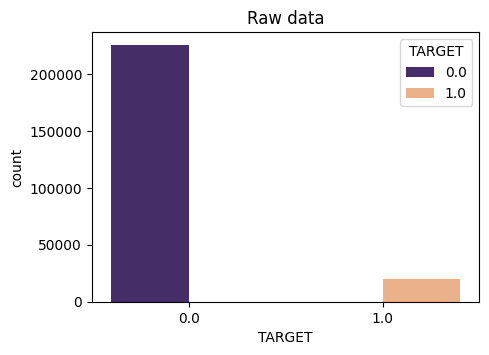

In [272]:
y_train_pd = pd.DataFrame(y_train)
plt.figure(figsize = (5,3.5))
Bar_chart = sns.countplot(data = y_train_pd, x = 'TARGET', hue = 'TARGET', palette = ['#432371',"#FAAE7B"])
plt.title("Raw data")

##### Random Under-Sampling

In [27]:
rand_under_sample = RandomUnderSampler()
x_train_rand, y_train_rand = rand_under_sample.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'Random Under-Sampled data')

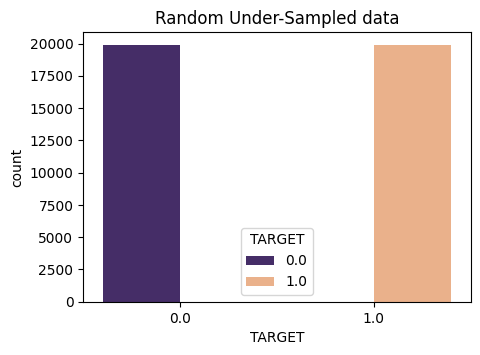

In [273]:
plt.figure(figsize = (5,3.5))
Bar_chart = sns.countplot(data = pd.DataFrame(y_train_rand), x = 'TARGET', hue = "TARGET", 
                          palette = ['#432371',"#FAAE7B"])
plt.title("Random Under-Sampled data")

##### SMOTE

In [274]:
#perform SMOTE under-sampling on training dataset
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'SMOTE data')

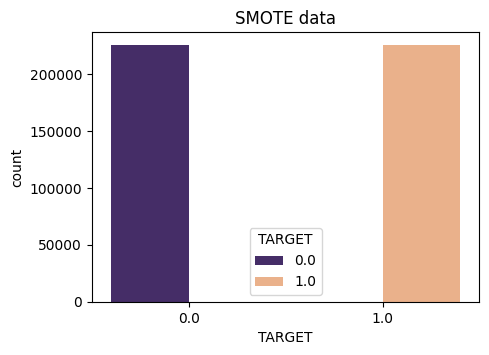

In [275]:
plt.figure(figsize = (5,3.5))
Bar_chart = sns.countplot(data = pd.DataFrame(y_train_smote), x = 'TARGET', hue = "TARGET", 
                          palette = ['#432371',"#FAAE7B"])

plt.title("SMOTE data")

# Classification

#### Comparison of different models

In [31]:
###############################
#Scores of models
###############################
def Model(model, X_train, X_test, y_train, y_test):
    
    
    from sklearn.metrics import fbeta_score, accuracy_score
    start = time.time()
      
    #Teach a model
    model.fit(X_train, y_train)
    
    #Prediction for the test part
    y_pred = model.predict(X_test)

    #metrics
    score = round(model.score(X_train, y_train), 3)
    acc = round(roc_auc_score(y_test, y_pred), 3)
    F1 = round(fbeta_score(y_test, y_pred, beta = 1), 3)
    F2 = round(fbeta_score(y_test, y_pred, beta = 2), 3)
    
    end = time.time()
    time_calc = round(end - start, 2)
    
    #DataFrame
    model_score = pd.DataFrame([score, acc, F1, F2, time_calc]).transpose()
    model_score.columns = ['score', 'AUC', 'F1', 'F2', 'Time']
    
    return model_score

#### Simple classifications

In [32]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(strategy = 'stratified')

scores_dummy = Model(clf_dummy, X_train, X_test, y_train, y_test)
scores_dummy

score    AUC     F1     F2  Time
0  0.852  0.499  0.079  0.079  0.12

In [33]:
#Dummy with random under-sampling
scores_dummy_rand = Model(clf_dummy, x_train_rand, X_test, y_train_rand, y_test)
scores_dummy_rand

score    AUC     F1     F2  Time
0  0.503  0.502  0.139  0.246   0.1

In [34]:
#Dummy with SMOTE under-sampling
scores_dummy_smote = Model(clf_dummy, x_train_smote, X_test, y_train_smote, y_test)
scores_dummy_smote

score  AUC     F1     F2  Time
0  0.499  0.5  0.138  0.243  0.17

##### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

clf_rand_forest = RandomForestClassifier(max_depth = 20, random_state = 20)

scores_rand_forest = Model(clf_rand_forest, X_train, X_test, y_train, y_test)
scores_rand_forest

score  AUC     F1     F2    Time
0  0.939  0.5  0.001  0.001  167.35

In [36]:
#Random Forest with random under-sampling
scores_rand_forest_rand = Model(clf_rand_forest, x_train_rand, X_test, y_train_rand, y_test)
scores_rand_forest_rand

score    AUC     F1     F2   Time
0  0.996  0.679  0.254  0.405  24.54

In [37]:
#Random Forest with smote under-sampling
scores_rand_forest_smote = Model(clf_rand_forest, x_train_smote, X_test, y_train_smote, y_test)
scores_rand_forest_smote

score    AUC     F1     F2    Time
0  0.985  0.508  0.035  0.023  383.17

##### Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier

clf_des_tree = DecisionTreeClassifier(max_depth = 20)
scores_des_tree = Model(clf_des_tree, X_train, X_test, y_train, y_test)
scores_des_tree

score    AUC     F1     F2   Time
0  0.958  0.536  0.142  0.119  70.43

In [39]:
#Decision tree with random under-sampling
scores_des_tree_rand = Model(clf_des_tree, x_train_rand, X_test, y_train_rand, y_test)
scores_des_tree_rand

score    AUC     F1    F2  Time
0  0.965  0.604  0.195  0.33  9.27

In [40]:
#Decision tree with smote under-sampling
scores_des_tree_smote = Model(clf_des_tree, x_train_smote, X_test, y_train_smote, y_test)
scores_des_tree_smote

score   AUC     F1     F2    Time
0  0.975  0.54  0.153  0.149  112.68

##### XGBoost

In [44]:
#XGBoost Classifier
import xgboost
from xgboost import XGBClassifier

clf_xgb = XGBClassifier()
scores_xgb = Model(clf_xgb, X_train, X_test, y_train, y_test)
scores_xgb

score    AUC     F1     F2    Time
0   0.93  0.529  0.115  0.079  157.35

In [45]:
#XGBoost with random under-sampling
scores_xgb_rand = Model(clf_xgb, x_train_rand, X_test, y_train_rand, y_test)
scores_xgb_rand

score    AUC     F1     F2   Time
0  0.874  0.696  0.268  0.424  27.57

In [46]:
#XGBoost with smote under-sampling
scores_xgb_smote = Model(clf_xgb, x_train_smote, X_test, y_train_smote, y_test)
scores_xgb_smote

score    AUC     F1     F2    Time
0  0.961  0.526  0.103  0.071  500.25

##### LGBM

In [41]:
#LGBM
from lightgbm import LGBMClassifier

clf_lgbm = LGBMClassifier()
scores_lgbm = Model(clf_lgbm, X_train, X_test, y_train, y_test)
scores_lgbm

score    AUC     F1     F2   Time
0  0.922  0.519  0.075  0.049  20.52

In [42]:
#LGBM with random under-sampling
scores_lgbm_rand = Model(clf_lgbm, x_train_rand, X_test, y_train_rand, y_test)
scores_lgbm_rand

score    AUC    F1     F2  Time
0  0.776  0.711  0.28  0.441  7.63

In [43]:
#LGBM with smote under-sampling
scores_lgbm_smote = Model(clf_lgbm, x_train_smote, X_test, y_train_smote, y_test)
scores_lgbm_smote

score    AUC     F1    F2   Time
0  0.956  0.515  0.061  0.04  36.67

##### Comparison of models

In [47]:
#DataFrame
index = pd.Index(['Dummy','Random Forest','Decision Tree','XGBoost','LGBM'])
models_comp = pd.concat([scores_dummy, scores_rand_forest, scores_des_tree,
                         scores_xgb, scores_lgbm], axis = 0)
models_comp = models_comp.set_index(index)
models_comp

score    AUC     F1     F2    Time
Dummy          0.852  0.499  0.079  0.079    0.12
Random Forest  0.939  0.500  0.001  0.001  167.35
Decision Tree  0.958  0.536  0.142  0.119   70.43
XGBoost        0.930  0.529  0.115  0.079  157.35
LGBM           0.922  0.519  0.075  0.049   20.52

In [48]:
#DataFrame
index = pd.Index(['Dummy','Random Forest','Decision Tree','XGBoost','LGBM'])
models_comp_rand = pd.concat([scores_dummy_rand, scores_rand_forest_rand, scores_des_tree_rand,
                         scores_xgb_rand, scores_lgbm_rand], axis = 0)
models_comp_rand = models_comp_rand.set_index(index)
models_comp_rand

score    AUC     F1     F2   Time
Dummy          0.503  0.502  0.139  0.246   0.10
Random Forest  0.996  0.679  0.254  0.405  24.54
Decision Tree  0.965  0.604  0.195  0.330   9.27
XGBoost        0.874  0.696  0.268  0.424  27.57
LGBM           0.776  0.711  0.280  0.441   7.63

In [49]:
#DataFrame
index = pd.Index(['Dummy','Random Forest','Decision Tree','XGBoost','LGBM'])
models_comp_smote = pd.concat([scores_dummy_smote, scores_rand_forest_smote, scores_des_tree_smote,
                         scores_xgb_smote, scores_lgbm_smote], axis = 0)
models_comp_smote = models_comp_smote.set_index(index)
models_comp_smote

score    AUC     F1     F2    Time
Dummy          0.499  0.500  0.138  0.243    0.17
Random Forest  0.985  0.508  0.035  0.023  383.17
Decision Tree  0.975  0.540  0.153  0.149  112.68
XGBoost        0.961  0.526  0.103  0.071  500.25
LGBM           0.956  0.515  0.061  0.040   36.67

### Feature Importance (only for random under-sampling)

##### Global feature importance

In [88]:
################################
#Global Feature Importance
################################
def features_import(model, X_train, X_test, y_train, y_test):
    
    #model.fit(train_x, train_y, eval_metric = 'auc')
    model.fit(X_train, y_train)
    #y_pred = model.predict(y_test)
    
    feats = [f for f in X_train.columns if f not in ['TARGET']]
    importance = model.feature_importances_
    tot = importance.sum()
    feature_importance_df = pd.DataFrame()
    feature_importance_df["feature"] = feats 
    #feature_importance_df["importance"] = importance/tot.values[0]
    feature_importance_df["importance"] = importance/tot
    
    return feature_importance_df


#Plot feature importance
def display_importances(feature_importance, num_feat):
    
    best_feat = feature_importance.sort_values(by = "importance", ascending = False)[:num_feat]
    
    plt.figure(figsize = (6,4))
    sns.barplot(x = "importance", y = "feature", data = best_feat)
    plt.title('Features importance')
    plt.show()
    
#Best features
def best_features(model, X_train, X_test, y_train, y_test, num_feat):
    #Features importance
    feature_importance_mod = features_import(model, X_train, X_test, y_train, y_test)
    best_feat = feature_importance_mod.sort_values(by = "importance", ascending = False)
    display_importances(best_feat, num_feat)
    #Accumulated probability
    best_feat = best_feat.reset_index(drop = True)
    best_feat['probability_accum'] = best_feat['importance'].cumsum()
    #plot
    plt.plot(best_feat[['probability_accum']].values)
    plt.xlabel('Number of features')
    plt.ylabel('Accumulated probability')
    plt.title('Features importance')
    plt.show()
    
    for i, value in enumerate(best_feat[['probability_accum']].values):
        if value > 0.9:
            print('Recommended number of features to achieve 90% of variance is', i)
            break
    feat_num = i
    return best_feat, feat_num

In [ ]:
#Random Forest
best_feat_rand_forest, feat_num_rand_forest = best_features(clf_rand_forest, x_train_rand, X_test, y_train_rand, 
                                                            y_test, num_feat = 15)

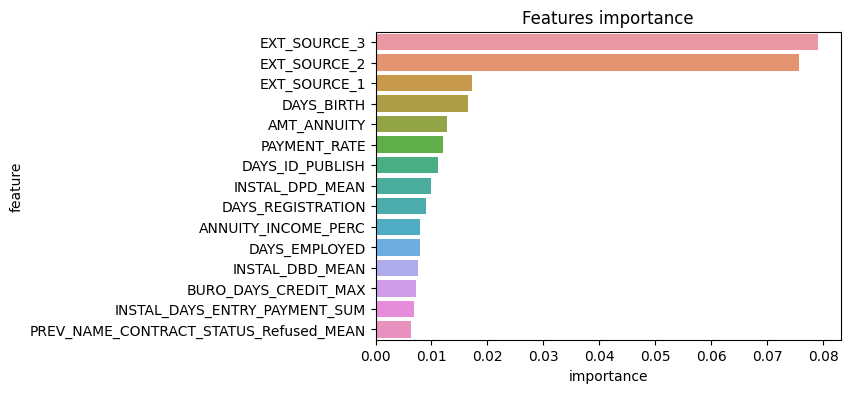

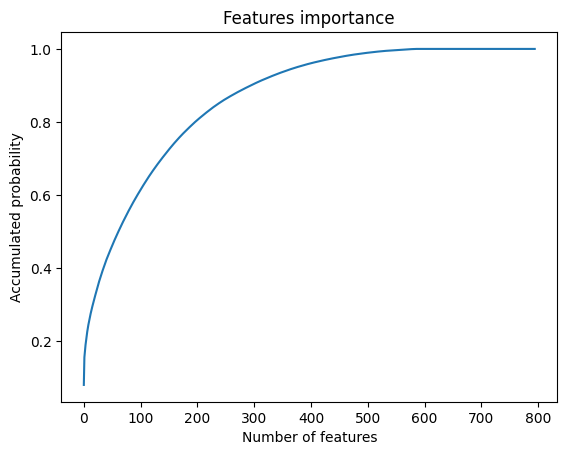

Recommended number of features to achieve 90% of variance is 295


In [89]:
#Decision Tree
best_feat_des_tree, feat_num_des_tree = best_features(clf_des_tree, x_train_rand, X_test, y_train_rand, 
                                                            y_test, num_feat = 15)

In [ ]:
#XGBoost
best_feat_xgb, feat_num_xgb = best_features(clf_xgb, x_train_rand, X_test, y_train_rand, y_test, num_feat = 15)

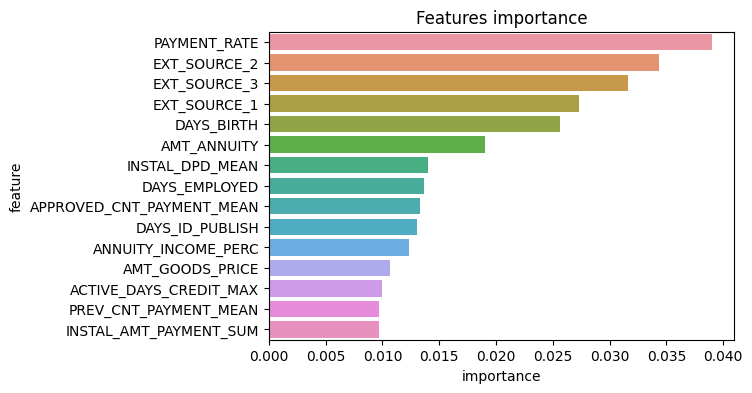

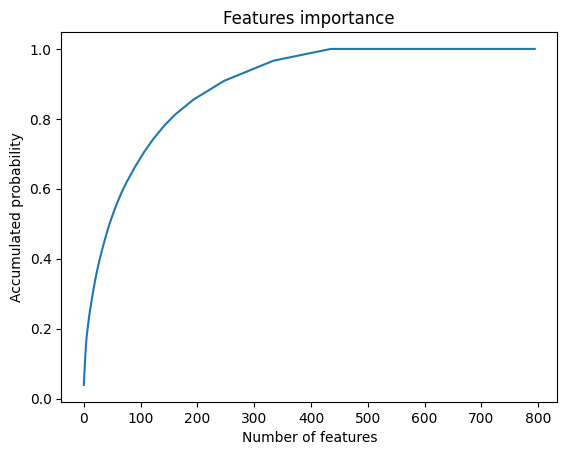

Recommended number of features to achieve 90% of variance is 239
[CV 1/3; 1/45] START max_depth=2, max_features=220, max_leaf_nodes=2............
[CV 1/3; 1/45] END max_depth=2, max_features=220, max_leaf_nodes=2;, score=-34213.000 total time=   1.9s
[CV 3/3; 5/45] START max_depth=2, max_features=220, max_leaf_nodes=10...........
[CV 3/3; 5/45] END max_depth=2, max_features=220, max_leaf_nodes=10;, score=-18840.000 total time=   0.9s
[CV 2/3; 6/45] START max_depth=2, max_features=240, max_leaf_nodes=2............
[CV 2/3; 6/45] END max_depth=2, max_features=240, max_leaf_nodes=2;, score=-31073.000 total time=   1.2s
[CV 1/3; 10/45] START max_depth=2, max_features=240, max_leaf_nodes=10..........
[CV 1/3; 10/45] END max_depth=2, max_features=240, max_leaf_nodes=10;, score=-31377.000 total time=   0.7s
[CV 2/3; 12/45] START max_depth=2, max_features=260, max_leaf_nodes=4...........
[CV 2/3; 12/45] END max_depth=2, max_features=260, max_leaf_nodes=4;, score=-23293.000 total time=   1.0s
[

[CV 2/3; 1/45] START max_depth=2, max_features=220, max_leaf_nodes=2............
[CV 2/3; 1/45] END max_depth=2, max_features=220, max_leaf_nodes=2;, score=-24444.000 total time=   1.9s
[CV 2/3; 5/45] START max_depth=2, max_features=220, max_leaf_nodes=10...........
[CV 2/3; 5/45] END max_depth=2, max_features=220, max_leaf_nodes=10;, score=-24444.000 total time=   1.0s
[CV 3/3; 7/45] START max_depth=2, max_features=240, max_leaf_nodes=4............
[CV 3/3; 7/45] END max_depth=2, max_features=240, max_leaf_nodes=4;, score=-24532.000 total time=   1.2s
[CV 3/3; 10/45] START max_depth=2, max_features=240, max_leaf_nodes=10..........
[CV 3/3; 10/45] END max_depth=2, max_features=240, max_leaf_nodes=10;, score=-19265.000 total time=   0.7s
[CV 2/3; 13/45] START max_depth=2, max_features=260, max_leaf_nodes=6...........
[CV 2/3; 13/45] END max_depth=2, max_features=260, max_leaf_nodes=6;, score=-40490.000 total time=   0.9s
[CV 3/3; 14/45] START max_depth=2, max_features=260, max_leaf_node

[CV 3/3; 2/45] START max_depth=2, max_features=220, max_leaf_nodes=4............
[CV 3/3; 2/45] END max_depth=2, max_features=220, max_leaf_nodes=4;, score=-41887.000 total time=   1.8s
[CV 3/3; 3/45] START max_depth=2, max_features=220, max_leaf_nodes=6............
[CV 3/3; 3/45] END max_depth=2, max_features=220, max_leaf_nodes=6;, score=-29087.000 total time=   1.0s
[CV 2/3; 8/45] START max_depth=2, max_features=240, max_leaf_nodes=6............
[CV 2/3; 8/45] END max_depth=2, max_features=240, max_leaf_nodes=6;, score=-31073.000 total time=   1.1s
[CV 2/3; 9/45] START max_depth=2, max_features=240, max_leaf_nodes=8............
[CV 2/3; 9/45] END max_depth=2, max_features=240, max_leaf_nodes=8;, score=-40490.000 total time=   0.7s
[CV 1/3; 12/45] START max_depth=2, max_features=260, max_leaf_nodes=4...........
[CV 1/3; 12/45] END max_depth=2, max_features=260, max_leaf_nodes=4;, score=-40493.000 total time=   1.0s
[CV 2/3; 15/45] START max_depth=2, max_features=260, max_leaf_nodes=1

[CV 2/3; 3/45] START max_depth=2, max_features=220, max_leaf_nodes=6............
[CV 2/3; 3/45] END max_depth=2, max_features=220, max_leaf_nodes=6;, score=-24444.000 total time=   1.8s
[CV 3/3; 4/45] START max_depth=2, max_features=220, max_leaf_nodes=8............
[CV 3/3; 4/45] END max_depth=2, max_features=220, max_leaf_nodes=8;, score=-22471.000 total time=   1.0s
[CV 2/3; 7/45] START max_depth=2, max_features=240, max_leaf_nodes=4............
[CV 2/3; 7/45] END max_depth=2, max_features=240, max_leaf_nodes=4;, score=-23293.000 total time=   1.3s
[CV 1/3; 11/45] START max_depth=2, max_features=260, max_leaf_nodes=2...........
[CV 1/3; 11/45] END max_depth=2, max_features=260, max_leaf_nodes=2;, score=-22127.000 total time=   0.9s
[CV 1/3; 14/45] START max_depth=2, max_features=260, max_leaf_nodes=8...........
[CV 1/3; 14/45] END max_depth=2, max_features=260, max_leaf_nodes=8;, score=-24224.000 total time=   0.7s
[CV 3/3; 16/45] START max_depth=7, max_features=220, max_leaf_nodes=

In [92]:
#LGBM
best_feat_lgbm, feat_num_lgbm = best_features(clf_lgbm, x_train_rand, X_test, y_train_rand, y_test, num_feat = 15)

##### Local feature importance

In [70]:
################################
#Local feature importance (SHAP)
################################
def loc_feature_importance(model, X_train, X_test, y_train, y_test, num, num_feat, feat_num_model):

    #Fit the model
    model.fit(X_train, y_train)
    
    # load JS visualization code to notebook
    shap.initjs()
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    #Force plot
    i = num
    shap.force_plot(explainer.expected_value[0], np.array(shap_values)[0][i], features = X_train.iloc[i], 
                feature_names = X_train.columns)
    #plt.show()
    
    #Summary plot
    shap.summary_plot(shap_values, features = X_train, feature_names = X_train.columns, max_display = num_feat)
    plt.show()
    
    #Features importance
    feat_shap = pd.DataFrame(np.array(shap_values)[0], columns = X_train.columns)
    vals = np.abs(feat_shap.values).mean(0)
    
    shap_importance = pd.DataFrame(list(zip(X_train.columns, vals)),
                                  columns=['col_name','importance value'])
    shap_importance.sort_values(by = ['importance value'],
                                ascending = False, inplace = True)
    
    return shap_importance[:feat_num_model]

In [ ]:
#Random Forest
loc_feat_rand_forest = loc_feature_importance(clf_rand_forest, x_train_rand, X_test, y_train_rand, y_test, 
                                              num = 0, num_feat = 10, feat_num_model = 10)

In [ ]:
#Decision Tree
loc_feat_des_tree = loc_feature_importance(clf_des_tree, x_train_rand, X_test, y_train_rand, y_test, 
                                              num = 0, num_feat = 10, feat_num_model = 10)

In [ ]:
#XGBoost
loc_feat_xgb = loc_feature_importance(clf_xgb, x_train_rand, X_test, y_train_rand, y_test, 
                                              num = 0, num_feat = 10, feat_num_model = 10)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


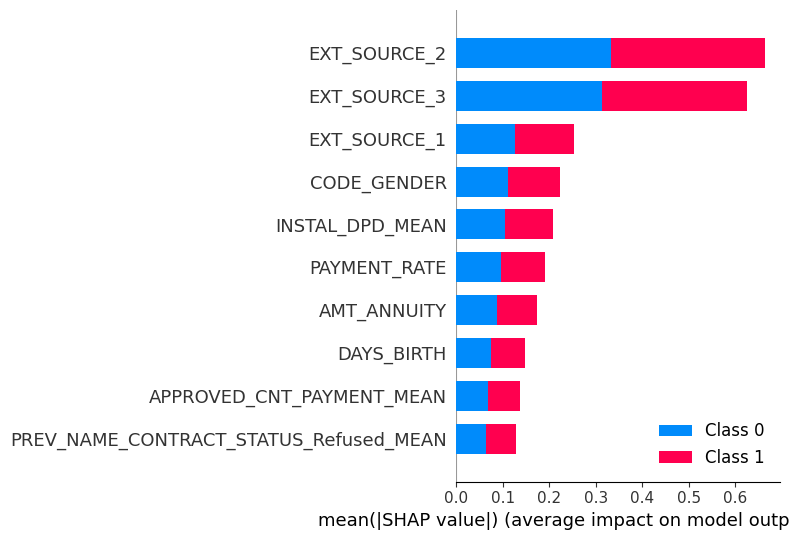

In [71]:
#LGBM
loc_feat_lgbm = loc_feature_importance(clf_lgbm, x_train_rand, X_test, y_train_rand, y_test, 
                                              num = 0, num_feat = 10, feat_num_model = 10)

In [50]:
import shap
shap.initjs()

In [51]:
explainer = shap.TreeExplainer(clf_lgbm)
shap_values = explainer.shap_values(x_train_rand)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [58]:
i = 0
num_feat = 10
shap.force_plot(explainer.expected_value[0], np.array(shap_values)[0][i], features = x_train_rand.iloc[i], 
                feature_names = x_train_rand.columns)
#plt.show()

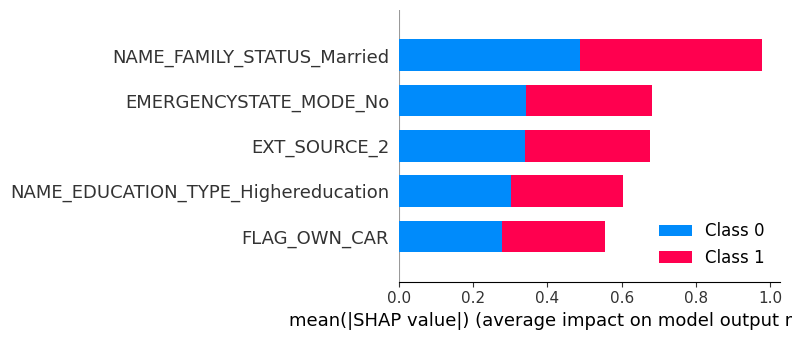

<Figure size 500x300 with 0 Axes>

In [277]:
#Summary plot
shap.summary_plot(shap_values, features = x_train_rand, feature_names = x_train_rand.columns, max_display = 5)
plt.gcf().set_size_inches(5,3)
plt.show()

In [64]:
#Features importance
feat_shap = pd.DataFrame(np.array(shap_values)[0], columns = x_train_rand.columns)
vals = np.abs(feat_shap.values).mean(0)
shap_importance = pd.DataFrame(list(zip(x_train_rand.columns, vals)), columns = ['col_name','importance value'])

In [65]:
shap_importance

col_name  importance value
0                         CODE_GENDER          0.243132
1                        FLAG_OWN_CAR          0.277010
2                     FLAG_OWN_REALTY          0.050107
3                        CNT_CHILDREN          0.145719
4                    AMT_INCOME_TOTAL          0.002615
..                                ...               ...
790   CC_NAME_CONTRACT_STATUS_nan_MAX          0.000000
791  CC_NAME_CONTRACT_STATUS_nan_MEAN          0.000000
792   CC_NAME_CONTRACT_STATUS_nan_SUM          0.000000
793   CC_NAME_CONTRACT_STATUS_nan_VAR          0.000000
794                          CC_COUNT          0.000000

[795 rows x 2 columns]

In [68]:
shap_importance.sort_values(by = ['importance value'], ascending = False, inplace = True)
shap_importance

col_name  importance value
130                        NAME_FAMILY_STATUS_Married          0.488663
238                            EMERGENCYSTATE_MODE_No          0.340996
31                                       EXT_SOURCE_2          0.338420
125               NAME_EDUCATION_TYPE_Highereducation          0.301820
1                                        FLAG_OWN_CAR          0.277010
..                                                ...               ...
623  POS_NAME_CONTRACT_STATUS_Returnedtothestore_MEAN          0.000000
624              POS_NAME_CONTRACT_STATUS_Signed_MEAN          0.000000
625                 POS_NAME_CONTRACT_STATUS_XNA_MEAN          0.000000
626                 POS_NAME_CONTRACT_STATUS_nan_MEAN          0.000000
794                                          CC_COUNT          0.000000

[795 rows x 2 columns]

### GridSearch and Cross Validation

In [75]:
def score_metier(y, y_pred):
    
    from sklearn.metrics import confusion_matrix
    
    conf_mat = confusion_matrix(y, y_pred)
    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    cost = 10*FN + FP
    
    return cost

In [76]:
# Cross validation model
def cross_val(model, X_train, X_test, y_train, y_test, num_folds):
    
    from sklearn.model_selection import cross_val_score
    #from sklearn.metrics import confusion_matrix
    
    folds = KFold(n_splits = num_folds, shuffle = True, random_state = 1001)
        
    y_preds_idx = np.zeros(X_train.shape[0])
    sub_preds = np.zeros(X_test.shape[0])
    
    score_mod = 0
    score_met = 10**10
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x_nf, train_y_nf = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x_nf, valid_y_nf = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        
        model.fit(train_x_nf, train_y_nf)
        y_pred_nf = model.predict(valid_x_nf)
        #Confusion matrix
        #cm_nf = confusion_matrix(valid_y_nf, y_pred_nf)
        #print(cm_nf)
        #FP_nf = cm_nf[0][1]
        #print('False Positive %.6f' % FP_nf)
        #FN_nf = cm_nf[1][0]
        #print('False Negative %.6f' % FN_nf)
        #score_met_nf = 10*FN_nf + FP_nf
        #print('Score %.6f' % score_met_nf)
        cost_nf = score_metier(valid_y_nf, y_pred_nf)  
        score_met = min(score_met, cost_nf)
        score_nf = roc_auc_score(valid_y_nf, y_pred_nf)
        score_mod = score_mod + score_nf
        
    score_mod = round(score_mod/num_folds, 3)
    #print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))    
    #print('Cross validation score %.6f' % score_mod)
    
    #DataFrame
    score_cv = pd.DataFrame([score_mod, score_met]).transpose()
    score_cv.columns = ['Averaged AUC', 'Score Metier']
    
    return score_cv

In [80]:
#Random forest
score_cv_rand_forest = cross_val(clf_rand_forest, x_train_rand, X_test, y_train_rand, y_test, num_folds = 10)
score_cv_rand_forest

Averaged AUC  Score Metier
0         0.679        6788.0

In [81]:
#Decision Tree
score_cv_des_tree = cross_val(clf_des_tree, x_train_rand, X_test, y_train_rand, y_test, num_folds = 10)
score_cv_des_tree

Averaged AUC  Score Metier
0         0.604        8281.0

In [82]:
#XGBoost
score_cv_xgb = cross_val(clf_xgb, x_train_rand, X_test, y_train_rand, y_test, num_folds = 10)
score_cv_xgb

Averaged AUC  Score Metier
0         0.698        6378.0

In [79]:
#LGBM
score_cv_lgbm = cross_val(clf_lgbm, x_train_rand, X_test, y_train_rand, y_test, num_folds = 10)
score_cv_lgbm

Averaged AUC  Score Metier
0         0.707        6129.0

In [83]:
#DataFrame
index_cv = pd.Index(['Random Forest','Decision Tree','XGBoost','LGBM'])
models_comp_cv_rand = pd.concat([score_cv_rand_forest, score_cv_des_tree, score_cv_xgb, score_cv_lgbm], axis = 0)
models_comp_cv_rand = models_comp_cv_rand.set_index(index_cv)
models_comp_cv_rand

Averaged AUC  Score Metier
Random Forest         0.679        6788.0
Decision Tree         0.604        8281.0
XGBoost               0.698        6378.0
LGBM                  0.707        6129.0

In [86]:
###########################
#Hyperparameters
###########################
    
def GridSearch(model, X_train, X_test, y_train, y_test, hyper_params, num_folds = 3, n_jobs = -1):
    
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer
    
    #create a cross-validation scheme
    folds = KFold(n_splits = num_folds, shuffle = True, random_state = 1001)
    #Create scoring
    score_met = make_scorer(score_metier, greater_is_better = False)

    #train model
    #model.fit(X_train, y_train)    
    
    #GridSearchCV()
    model_cv = GridSearchCV(model, 
                        param_grid = hyper_params, 
                        scoring = score_met,
                        cv = folds, 
                        verbose = 100,
                        n_jobs = -1)

    # fit the model
    model_cv.fit(X_train, y_train)
    
    #Prediction for the test part
    #y_pred = model.predict(X_test)

    # cv results
    cv_results = pd.DataFrame(model_cv.cv_results_)
    
    # #Best parameters
    best_param = model_cv.best_params_
    best_comb = model_cv.best_estimator_
    

    print ('Best Parameters: ', model_cv.best_params_, ' \n')
    
    return cv_results, best_comb

In [91]:
#Decision Tree
hyper_params_des_tree = {'max_features': list(range(240, 300+1, 20)),
                          'max_leaf_nodes': list(range(2, 7, 2)),
                          'max_depth':list(range(2,16,5))}

cv_res_des_tree, best_comb_des_tree = GridSearch(clf_des_tree, x_train_rand, X_test, y_train_rand, y_test, 
                                                 hyper_params_des_tree, num_folds = 5, n_jobs = -1)
best_comb_des_tree

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters:  {'max_depth': 7, 'max_features': 300, 'max_leaf_nodes': 2}  



DecisionTreeClassifier(max_depth=7, max_features=300, max_leaf_nodes=2)

In [253]:
#LGBM
hyper_params_lgbm = {'max_features': list(range(200, 240+1, 20)),
                     #'nthread': list(range(2, 8, 2)),
                     'n_estimators': [10, 100, 1000],
                     'num_leaves':list(range(30,51,5)),
                     'max_depth':list(range(2,9,2))
                    }

cv_res_lgbm, best_comb_lgbm = GridSearch(clf_lgbm, x_train_rand, X_test, y_train_rand, y_test, 
                                         hyper_params_lgbm, num_folds = 5)
best_comb_lgbm

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[LightGBM] [Warning] Unknown parameter: max_features
Best Parameters:  {'max_depth': 6, 'max_features': 200, 'n_estimators': 100, 'num_leaves': 40}  



LGBMClassifier(max_depth=6, max_features=200, num_leaves=40)

[CV 1/5; 2/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=35
[LightGBM] [Warning] Unknown parameter: max_features
[CV 1/5; 2/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=35;, score=-15862.000 total time=   5.7s
[CV 5/5; 2/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=35
[LightGBM] [Warning] Unknown parameter: max_features
[CV 5/5; 2/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=35;, score=-14929.000 total time=   5.4s
[CV 1/5; 5/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=50
[LightGBM] [Warning] Unknown parameter: max_features
[CV 1/5; 5/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=50;, score=-15862.000 total time=   5.4s
[CV 1/5; 7/180] START max_depth=2, max_features=200, n_estimators=100, num_leaves=35
[LightGBM] [Warning] Unknown parameter: max_features
[CV 1/5; 7/180] END max_depth=2, max_features=200, n_estimators=100, num_leaves=35;, score=

[CV 2/5; 1/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=30
[LightGBM] [Warning] Unknown parameter: max_features
[CV 2/5; 1/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=30;, score=-16252.000 total time=   6.2s
[CV 1/5; 4/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=45
[LightGBM] [Warning] Unknown parameter: max_features
[CV 1/5; 4/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=45;, score=-15862.000 total time=   4.7s
[CV 3/5; 5/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=50
[LightGBM] [Warning] Unknown parameter: max_features
[CV 3/5; 5/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=50;, score=-15345.000 total time=   5.1s
[CV 3/5; 6/180] START max_depth=2, max_features=200, n_estimators=100, num_leaves=30
[LightGBM] [Warning] Unknown parameter: max_features
[CV 3/5; 6/180] END max_depth=2, max_features=200, n_estimators=100, num_leaves=30;, score=

[CV 4/5; 1/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=30
[LightGBM] [Warning] Unknown parameter: max_features
[CV 4/5; 1/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=30;, score=-16434.000 total time=   5.8s
[CV 4/5; 3/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=40
[LightGBM] [Warning] Unknown parameter: max_features
[CV 4/5; 3/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=40;, score=-16434.000 total time=   5.0s
[CV 2/5; 4/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=45
[LightGBM] [Warning] Unknown parameter: max_features
[CV 2/5; 4/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=45;, score=-16252.000 total time=   5.0s
[CV 1/5; 6/180] START max_depth=2, max_features=200, n_estimators=100, num_leaves=30
[LightGBM] [Warning] Unknown parameter: max_features
[CV 1/5; 6/180] END max_depth=2, max_features=200, n_estimators=100, num_leaves=30;, score=

[CV 1/5; 1/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=30
[LightGBM] [Warning] Unknown parameter: max_features
[CV 1/5; 1/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=30;, score=-15862.000 total time=   5.6s
[CV 4/5; 2/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=35
[LightGBM] [Warning] Unknown parameter: max_features
[CV 4/5; 2/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=35;, score=-16434.000 total time=   5.4s
[CV 4/5; 4/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=45
[LightGBM] [Warning] Unknown parameter: max_features
[CV 4/5; 4/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=45;, score=-16434.000 total time=   5.3s
[CV 5/5; 6/180] START max_depth=2, max_features=200, n_estimators=100, num_leaves=30
[LightGBM] [Warning] Unknown parameter: max_features
[CV 5/5; 6/180] END max_depth=2, max_features=200, n_estimators=100, num_leaves=30;, score=

[CV 3/5; 1/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=30
[LightGBM] [Warning] Unknown parameter: max_features
[CV 3/5; 1/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=30;, score=-15345.000 total time=   5.7s
[CV 2/5; 3/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=40
[LightGBM] [Warning] Unknown parameter: max_features
[CV 2/5; 3/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=40;, score=-16252.000 total time=   5.4s
[CV 4/5; 5/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=50
[LightGBM] [Warning] Unknown parameter: max_features
[CV 4/5; 5/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=50;, score=-16434.000 total time=   5.5s
[CV 2/5; 7/180] START max_depth=2, max_features=200, n_estimators=100, num_leaves=35
[LightGBM] [Warning] Unknown parameter: max_features
[CV 2/5; 7/180] END max_depth=2, max_features=200, n_estimators=100, num_leaves=35;, score=

[CV 5/5; 1/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=30
[LightGBM] [Warning] Unknown parameter: max_features
[CV 5/5; 1/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=30;, score=-14929.000 total time=   5.7s
[CV 1/5; 3/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=40
[LightGBM] [Warning] Unknown parameter: max_features
[CV 1/5; 3/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=40;, score=-15862.000 total time=   5.4s
[CV 5/5; 4/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=45
[LightGBM] [Warning] Unknown parameter: max_features
[CV 5/5; 4/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=45;, score=-14929.000 total time=   5.2s
[CV 4/5; 6/180] START max_depth=2, max_features=200, n_estimators=100, num_leaves=30
[LightGBM] [Warning] Unknown parameter: max_features
[CV 4/5; 6/180] END max_depth=2, max_features=200, n_estimators=100, num_leaves=30;, score=

[CV 3/5; 2/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=35
[LightGBM] [Warning] Unknown parameter: max_features
[CV 3/5; 2/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=35;, score=-15345.000 total time=   5.7s
[CV 3/5; 3/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=40
[LightGBM] [Warning] Unknown parameter: max_features
[CV 3/5; 3/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=40;, score=-15345.000 total time=   5.2s
[CV 3/5; 4/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=45
[LightGBM] [Warning] Unknown parameter: max_features
[CV 3/5; 4/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=45;, score=-15345.000 total time=   4.6s
[CV 5/5; 5/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=50
[LightGBM] [Warning] Unknown parameter: max_features
[CV 5/5; 5/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=50;, score=-1

[CV 2/5; 2/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=35
[LightGBM] [Warning] Unknown parameter: max_features
[CV 2/5; 2/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=35;, score=-16252.000 total time=   5.9s
[CV 5/5; 3/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=40
[LightGBM] [Warning] Unknown parameter: max_features
[CV 5/5; 3/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=40;, score=-14929.000 total time=   5.0s
[CV 2/5; 5/180] START max_depth=2, max_features=200, n_estimators=10, num_leaves=50
[LightGBM] [Warning] Unknown parameter: max_features
[CV 2/5; 5/180] END max_depth=2, max_features=200, n_estimators=10, num_leaves=50;, score=-16252.000 total time=   5.0s
[CV 2/5; 6/180] START max_depth=2, max_features=200, n_estimators=100, num_leaves=30
[LightGBM] [Warning] Unknown parameter: max_features
[CV 2/5; 6/180] END max_depth=2, max_features=200, n_estimators=100, num_leaves=30;, score=

### Final Prredction

##### LGBM

In [254]:
clf_clgm_opt = clf_clgm_opt = LGBMClassifier(max_features = 200, n_estimators = 100, 
                              num_leaves = 40, max_depth = 6, silent = -1, verbose = -1)

In [113]:
#train_x_wo_nan, train_y_wo_nan, test_x_wo_nan
x_train_rand_lgbm, y_train_rand_lgbm = rand_under_sample.fit_resample(X_train, y_train)

In [255]:
clf_clgm_opt.fit(x_train_rand_lgbm, y_train_rand_lgbm)

LGBMClassifier(max_depth=6, max_features=200, num_leaves=40, silent=-1,
               verbose=-1)

In [237]:
clf_clgm_opt

LGBMClassifier(max_depth=6, max_features=220, num_leaves=40, silent=-1,
               verbose=-1)

#### Save the model and data

In [238]:
file_model = 'finalized_model.sav'
pickle.dump(clf_clgm_opt, open(file_model, 'wb'))

In [251]:
#Save the data for test
file_data = 'data_clients.pickle'
pickle.dump(test_x_wo_nan, open(file_data, 'wb'))  

In [115]:
y_pred_lgbm = clf_clgm_opt.predict(test_x_wo_nan)

# Conclusion

The given data was unbalanced, we had to perform under-sampling to balance it to get accurate models. As the bank, if the model predicts too many true positives, this is not an issue. The bank would not give the loan to someone who could have repaid it. This isn't so great for the customers.

We found the most appropriate model and optimized hyperparameters for this model to achieve the better accuracy.